In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [26]:
path = './istanbul_stock_exchange_data.xlsx'
# read the ise data
df = pd.read_excel(path, sheet_name='original data', usecols='D:J',header=0, skiprows=1).iloc[0:530]
df.dropna(inplace=True)
X = df.to_numpy()

# change the column names to stocks
df.rename(columns=lambda x:'stocks', inplace=True)
print(df.head(5))

# read the results column
y_df = pd.read_excel(path, sheet_name='original data', usecols='C', header=0, skiprows=1).iloc[0:530]
y_df.dropna(inplace=True)
y = y_df.to_numpy()
print(y_df.head(5))

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(X)

     stocks    stocks    stocks    stocks    stocks    stocks    stocks
0 -0.004679  0.002193  0.003894  0.000000  0.031190  0.012698  0.028524
1  0.007787  0.008455  0.012866  0.004162  0.018920  0.011341  0.008773
2 -0.030469 -0.017833 -0.028735  0.017293 -0.035899 -0.017073 -0.020015
3  0.003391 -0.011726 -0.000466 -0.040061  0.028283 -0.005561 -0.019424
4 -0.021533 -0.019873 -0.012710 -0.004474 -0.009764 -0.010989 -0.007802
      ISE.1
0  0.038376
1  0.031813
2 -0.026353
3 -0.084716
4  0.009658
C:\Users\John\AppData\Local\Programs\Python\Python37\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\John\AppData\Local\Programs\Python\Python37\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


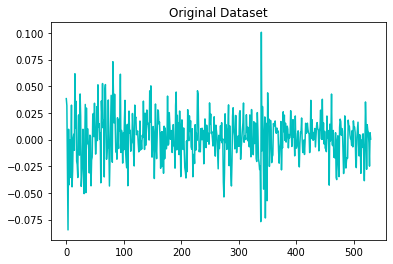

In [27]:
# plot the original values
plt.plot(y[:,0], c='c')
plt.title('Original Dataset')
plt.show()

In [28]:
# transform the dataset columns and shift the data according to: 
# in: previous months to use for prediction,
# out: months ahead to predict
def timeseries_to_supervised(df, n_in, n_out):
   agg = pd.DataFrame()

   for i in range(n_in, 0, -1):
      df_shifted = df.shift(i).copy()
      df_shifted.rename(columns=lambda x: (f'{x}(t-{i})'), inplace=True)
      agg = pd.concat([agg, df_shifted], axis=1)

   for i in range(0, n_out):
      df_shifted = df.shift(-i).copy()
      if i == 0:
         df_shifted.rename(columns=lambda x: (f'{x}(t)'), inplace=True)
      else:
         df_shifted.rename(columns=lambda x: (f'{x}(t+{i})'), inplace=True)
      agg = pd.concat([agg, df_shifted], axis=1)
   agg.dropna(inplace=True)
   return agg

n_in = 53
n_out = 1
shifted_df = timeseries_to_supervised(df, n_in, n_out)
print(shifted_df.columns)
print(shifted_df.head(5))

X = shifted_df[[(f'stocks(t-{i})') for i in range(53, 0, -1)]].values
y = shifted_df['stocks(t)'].values
print('X shape:', X.shape, 'y shape:', y.shape)

Index(['stocks(t-53)', 'stocks(t-53)', 'stocks(t-53)', 'stocks(t-53)',
       'stocks(t-53)', 'stocks(t-53)', 'stocks(t-53)', 'stocks(t-52)',
       'stocks(t-52)', 'stocks(t-52)',
       ...
       'stocks(t-1)', 'stocks(t-1)', 'stocks(t-1)', 'stocks(t)', 'stocks(t)',
       'stocks(t)', 'stocks(t)', 'stocks(t)', 'stocks(t)', 'stocks(t)'],
      dtype='object', length=378)
    stocks(t-53)  stocks(t-53)  stocks(t-53)  stocks(t-53)  stocks(t-53)  \
53     -0.004679      0.002193      0.003894      0.000000      0.031190   
54      0.007787      0.008455      0.012866      0.004162      0.018920   
55     -0.030469     -0.017833     -0.028735      0.017293     -0.035899   
56      0.003391     -0.011726     -0.000466     -0.040061      0.028283   
57     -0.021533     -0.019873     -0.012710     -0.004474     -0.009764   

    stocks(t-53)  stocks(t-53)  stocks(t-52)  stocks(t-52)  stocks(t-52)  ...  \
53      0.012698      0.028524      0.007787      0.008455      0.012866  ...   
54  

In [29]:
# split the data into training and test, 80/20 
data_len = X.shape[0]
train_size = int(data_len * .8)
test_size = data_len - train_size

x_train = X[:train_size,:]
y_train = y[:train_size,:]
x_test = X[train_size:,:] 
y_test = y[train_size:,:]
print(f'Train shape: { x_train.shape, y_train.shape }')
print(f'\nTest shape: { x_test.shape, y_test.shape }')

Train shape: ((381, 371), (381, 7))

Test shape: ((96, 371), (96, 7))


In [30]:
batch_size = 1 
# create the model
model = Sequential()

# initialize the model
model.add(Dense(50, input_dim=X.shape[1], activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(7))

print(model.summary())

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# fit the model
model.fit(x_train, y_train, epochs=25, batch_size=batch_size, verbose=1)

# predicting results
train_pred = model.predict(x_train, batch_size=batch_size)
test_pred = model.predict(x_test, batch_size=batch_size)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                18600     
_________________________________________________________________
dense_7 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 182       
Total params: 20,057
Trainable params: 20,057
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
381/381 [==============================] - 1s 603us/step - loss: 2.4103e-04
Epoch 2/25
381/381 [==============================] - 0s 608us/step - loss: 1.6150e-04
Epoch 3/25
381/381 [==============================] - 0s 611us/step - loss: 1.5539e-04
Epoch 4/25
381/381 [==============================] - 0s 605us/step - loss: 1.5099e-04
Epoch 5/25
381/381 [=======

In [33]:
# re-scale the prediction 
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform(y_train)
test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test)

In [34]:
# calculate the error
print('Test MSE: ', mean_squared_error(y_test, test_pred))
print('Test R2: ', r2_score(y_test, test_pred))

Test MSE:  1.2321116130294635e-06
Test R2:  -0.4046583842416927


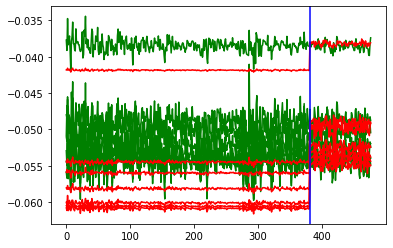

In [35]:
# Finally, we plot the results. A vertical line in the plot 
# identifies a splitting point between the training and the test data.
predicted = np.concatenate((train_pred,test_pred),axis=0)

original = np.concatenate((y_train, y_test),axis=0)
predicted = np.concatenate((train_pred, test_pred),axis=0)
index = range(0, original.shape[0])
plt.plot(index, original, c='g')
plt.plot(index, predicted, c='r')
plt.axvline(df.index[train_size], c='b')
plt.show()